# 3 - Failure prediction

In [1]:
%reload_ext watermark

In [2]:
import sklearn
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Union
import matplotlib.pyplot as plt

from scipy.stats import uniform, loguniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
%watermark --iversions

sklearn   : 1.6.1
matplotlib: 3.10.3
scipy     : 1.15.3
pandas    : 2.2.3
xgboost   : 3.0.2
seaborn   : 0.13.2
numpy     : 2.2.6



In [3]:
full_devices = pd.read_csv("full_devices.csv", encoding = "ISO-8859-1")
full_devices

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


In [4]:
y_col = "failure"
random_state = 27

In [5]:
# Describe function with different values to analyse
def explore_describe(df):
    df_out = pd.DataFrame(columns = ['variable','type','na' ,'na_pct' ,'unique','min', 'quat25','median','mean', \
                                     'quat75','max','std','skewness','kurtosis','media_desvio'])
    df_out['variable'] = df.columns
    df_out['type'] = df.dtypes.values
    df_out['na'] = [sum(df[coluna].isna()) for coluna in df.columns]
    df_out['na_pct'] = [str(round(100*sum(df[coluna].isna())/df.shape[0],1))+'%' for coluna in df.columns]
    df_out['unique'] = [len(df[coluna].unique()) for coluna in df.columns]
    df_out['min']  = [round(min(df[coluna]),2) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['mean'] = [round(df[coluna].mean(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['max']  = [round(max(df[coluna]),2) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['std'] = [round(df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat25'] = [round(df[coluna].quantile(0.25),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat75'] = [round(df[coluna].quantile(0.75),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['median'] = [round(df[coluna].quantile(0.5),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['skewness'] = [round(df[coluna].skew(),2) if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['kurtosis'] = [round(df[coluna].kurt(),2) if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    
    df_out_media_desvio_list = []
    for coluna in df.columns:
        if(('int' in str(df[coluna].dtype)) or ('float' in str(df[coluna].dtype)) ):
            if((all(df[coluna] == 0)) or (df[coluna].std() == 0)):
                df_out_media_desvio_list.append(0)
            else:
                df_out_media_desvio_list.append(round(df[coluna].mean()/df[coluna].std(),2))
        else:
            df_out_media_desvio_list.append('-')
    
    df_out['media_desvio'] = df_out_media_desvio_list
    return(df_out)

In [6]:
# No NaN values
explore_describe(full_devices)

,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,date,object,0,0.0%,304,-,-,-,-,-,-,-,-,-,-
1,device,object,0,0.0%,1169,-,-,-,-,-,-,-,-,-,-
2,failure,int64,0,0.0%,2,0,0.0,0.0,0.0,0.0,1,0.03,34.23,1169.52,0.03
3,attribute1,int64,0,0.0%,123877,0,61284762.0,122797388.0,122388103.24,183309640.0,244140480,70459334.22,-0.01,-1.2,1.74
4,attribute2,int64,0,0.0%,558,0,0.0,0.0,159.48,0.0,64968,2179.66,23.86,626.82,0.07
5,attribute3,int64,0,0.0%,47,0,0.0,0.0,9.94,0.0,24929,185.75,82.71,10473.59,0.05
6,attribute4,int64,0,0.0%,115,0,0.0,0.0,1.74,0.0,1666,22.91,41.5,2467.96,0.08
7,attribute5,int64,0,0.0%,60,1,8.0,10.0,14.22,12.0,98,15.94,3.48,12.15,0.89
8,attribute6,int64,0,0.0%,44838,8,221452.0,249799.5,260172.66,310266.0,689161,99151.08,-0.38,1.91,2.62
9,attribute7,int64,0,0.0%,28,0,0.0,0.0,0.29,0.0,832,7.44,73.48,6876.27,0.04


In [7]:
full_devices[y_col].value_counts(normalize=True)

failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64

# Train test split

We want to predict 1 day before the failure, and we will try to use a classical machine learning model. However, this dataset is not fittable for this task. We must transform this dataset, creating new features, where each record represents one day before the event.

For the attributes, let's consider some longitudinal values, like
- mean
- standard deviation
- count values lower than mean
- exponential mean
- number of records
- last value

In [8]:
# Converting the data type
full_devices["date"] = pd.to_datetime(full_devices["date"])

In [9]:
# Considering each device, how many failures do they have in this series?
# Just 1 failure per device
full_devices.groupby("device").failure.sum().value_counts(normalize=True)

failure
0    0.909324
1    0.090676
Name: proportion, dtype: float64

In [10]:
# Is there any device with just one record? This one can not be evaluated
one_record = full_devices.device.value_counts().pipe(lambda x: x[x == 1])
one_record

device
W1F1DA5ÿ    1
Name: count, dtype: int64

In [11]:
# In this case, we can split our data before the analysis
# per device
failure_devices = full_devices[~full_devices.isin(one_record.index)]\
    .groupby("device")\
    .failure.sum()
train_devices, test_devices = train_test_split(failure_devices.index,
                                               test_size=0.3,
                                               random_state=random_state,
                                               stratify=failure_devices)
df_train = full_devices[full_devices.device.isin(train_devices)]
df_test = full_devices[full_devices.device.isin(test_devices)]

# Feature Engineering

In [12]:
# Checking out some devices
d = df_train.query("failure == 0").device.iloc[0]
df_train.query(f"device == '{d}'")

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
1164,2015-01-02,S1F0166B,0,191946112,0,3,0,6,403174,0,0,0
2327,2015-01-03,S1F0166B,0,77681360,0,3,0,6,403174,0,0,0
3490,2015-01-04,S1F0166B,0,82195688,0,3,0,6,403175,0,0,0
4652,2015-01-05,S1F0166B,0,224339296,0,3,0,6,403812,0,0,0
5813,2015-01-06,S1F0166B,0,7441792,0,3,0,6,404786,0,0,0


In [13]:
d = df_train.query("failure == 1").device.iloc[0]
df_train.query(f"device == '{d}'")

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
235,2015-01-01,S1F0RRB1,0,5230888,2288,0,37,8,39267,24,24,1
1398,2015-01-02,S1F0RRB1,0,13307628,64776,0,49,8,39267,56,56,1
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,56,1
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,56,1
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1


In [14]:
class FeatEng:
    def __init__(self, ewm_alpha: float = 0.8, ewm_adjust: bool = False):
        self.alpha = ewm_alpha
        self.adjust = ewm_adjust

    def fit(self, X):
        self.x_features = [c for c in X.columns if "attribute" in c]
        return self

    def _new_record(self, X, d, y = None):
        X_ = X.query(f"device == '{d}'")
        if y is not None:
            y_ = y[y.index.isin(X_.index)].sum()
        else:
            y_ = None
        X_ = X_\
            .sort_values("date").set_index(["device", "date"])\
            .pipe(lambda x: x[self.x_features].iloc[:-1])
        # Creating the new features
        X_ = X_.assign(**{c + "_mean": X_[c].mean() for c in self.x_features})\
            .assign(**{c + "_std": X_[c].std() for c in self.x_features})\
            .assign(**{c + "_lower_mean": (X_[c].mean() > X_[c]).sum()
                       for c in self.x_features})\
            .assign(**{c + "_ewm": X_[c].ewm(alpha=self.alpha,
                                            adjust=self.adjust).mean()
                       for c in self.x_features})\
            .assign(n_records=lambda x: x.shape[0]).iloc[[-1]]
        return X_, y_
    def transform(self, X, y = None):
        self.new_records = [self._new_record(X, d, y) for d in X.device.unique()]
        if y is None:
            return pd.concat([nr[0] for nr in self.new_records])
        else:
            X_return = pd.concat([nr[0] for nr in self.new_records])
            y_return = pd.Series([nr[1] for nr in self.new_records],
                                 index=X_return.index,
                                 name="y")
            return X_return, y_return
            

In [15]:
f = FeatEng()
X_train, y_train = f.fit(df_train).transform(df_train.drop(columns=y_col), df_train[y_col])

# EDA

In [16]:
explore_describe(X_train)

,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,attribute1,int64,0,0.0%,817,543344.00,6.020000e+07,1.204413e+08,1.194811e+08,1.767734e+08,2.439724e+08,69837323.04,0.00,-1.18,1.71
1,attribute2,int64,0,0.0%,75,0.00,0.000000e+00,0.000000e+00,7.737200e+02,0.000000e+00,6.479200e+04,5903.11,9.90,101.01,0.13
2,attribute3,int64,0,0.0%,36,0.00,0.000000e+00,0.000000e+00,4.379000e+01,0.000000e+00,2.492900e+04,882.84,27.57,776.51,0.05
3,attribute4,int64,0,0.0%,44,0.00,0.000000e+00,0.000000e+00,4.990000e+00,0.000000e+00,7.630000e+02,39.12,14.61,241.22,0.13
4,attribute5,int64,0,0.0%,47,1.00,7.000000e+00,9.000000e+00,1.193000e+01,1.200000e+01,9.800000e+01,11.06,4.52,25.02,1.08
5,attribute6,int64,0,0.0%,796,18.00,2.110830e+05,2.621050e+05,2.705823e+05,3.290700e+05,6.840780e+05,103725.29,-0.30,1.54,2.61
6,attribute7,int64,0,0.0%,17,0.00,0.000000e+00,0.000000e+00,3.970000e+00,0.000000e+00,8.320000e+02,41.96,16.70,303.18,0.09
7,attribute8,int64,0,0.0%,17,0.00,0.000000e+00,0.000000e+00,3.970000e+00,0.000000e+00,8.320000e+02,41.96,16.70,303.18,0.09
8,attribute9,int64,0,0.0%,48,0.00,0.000000e+00,0.000000e+00,5.104000e+01,1.000000e+00,1.870100e+04,760.21,21.13,482.83,0.07
9,attribute1_mean,float64,0,0.0%,817,20695677.00,1.166624e+08,1.225639e+08,1.232226e+08,1.284856e+08,2.179241e+08,22097375.10,-0.03,4.15,5.58


In [17]:
# Lets create a StandarScaler
# This will make the analysis easier to plot (same scale)
# Besides, some models need attributes scaled
ss = StandardScaler().fit(X_train)
X_train_ = pd.DataFrame(ss.transform(X_train),
                        columns=ss.get_feature_names_out(),
                        index=X_train.index)

In [18]:
explore_describe(X_train_)

,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,attribute1,float64,0,0.0%,817,-1.70,-0.85,0.01,0.0,0.82,1.78,1.0,0.00,-1.18,0.0
1,attribute2,float64,0,0.0%,75,-0.13,-0.13,-0.13,0.0,-0.13,10.85,1.0,9.90,101.01,0.0
2,attribute3,float64,0,0.0%,36,-0.05,-0.05,-0.05,0.0,-0.05,28.21,1.0,27.57,776.51,0.0
3,attribute4,float64,0,0.0%,44,-0.13,-0.13,-0.13,-0.0,-0.13,19.39,1.0,14.61,241.22,-0.0
4,attribute5,float64,0,0.0%,47,-0.99,-0.45,-0.27,0.0,0.01,7.79,1.0,4.52,25.02,0.0
5,attribute6,float64,0,0.0%,796,-2.61,-0.57,-0.08,0.0,0.56,3.99,1.0,-0.30,1.54,0.0
6,attribute7,float64,0,0.0%,17,-0.09,-0.09,-0.09,-0.0,-0.09,19.75,1.0,16.70,303.18,-0.0
7,attribute8,float64,0,0.0%,17,-0.09,-0.09,-0.09,-0.0,-0.09,19.75,1.0,16.70,303.18,-0.0
8,attribute9,float64,0,0.0%,48,-0.07,-0.07,-0.07,0.0,-0.07,24.55,1.0,21.13,482.83,0.0
9,attribute1_mean,float64,0,0.0%,817,-4.64,-0.30,-0.03,-0.0,0.24,4.29,1.0,-0.03,4.15,-0.0


## Correlation

Text(0.5, 1.0, 'Correlation')

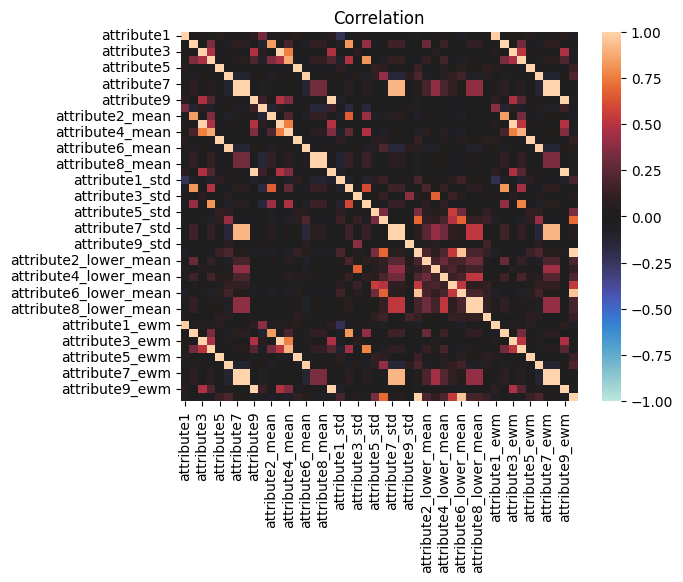

In [19]:
# It is expected new features have some correlation between the original ones
heatmap = sns.heatmap(X_train_.corr(), vmin = -1, vmax = 1, annot = False, cmap="icefire")
heatmap.set_title('Correlation')

## Last value vs failure

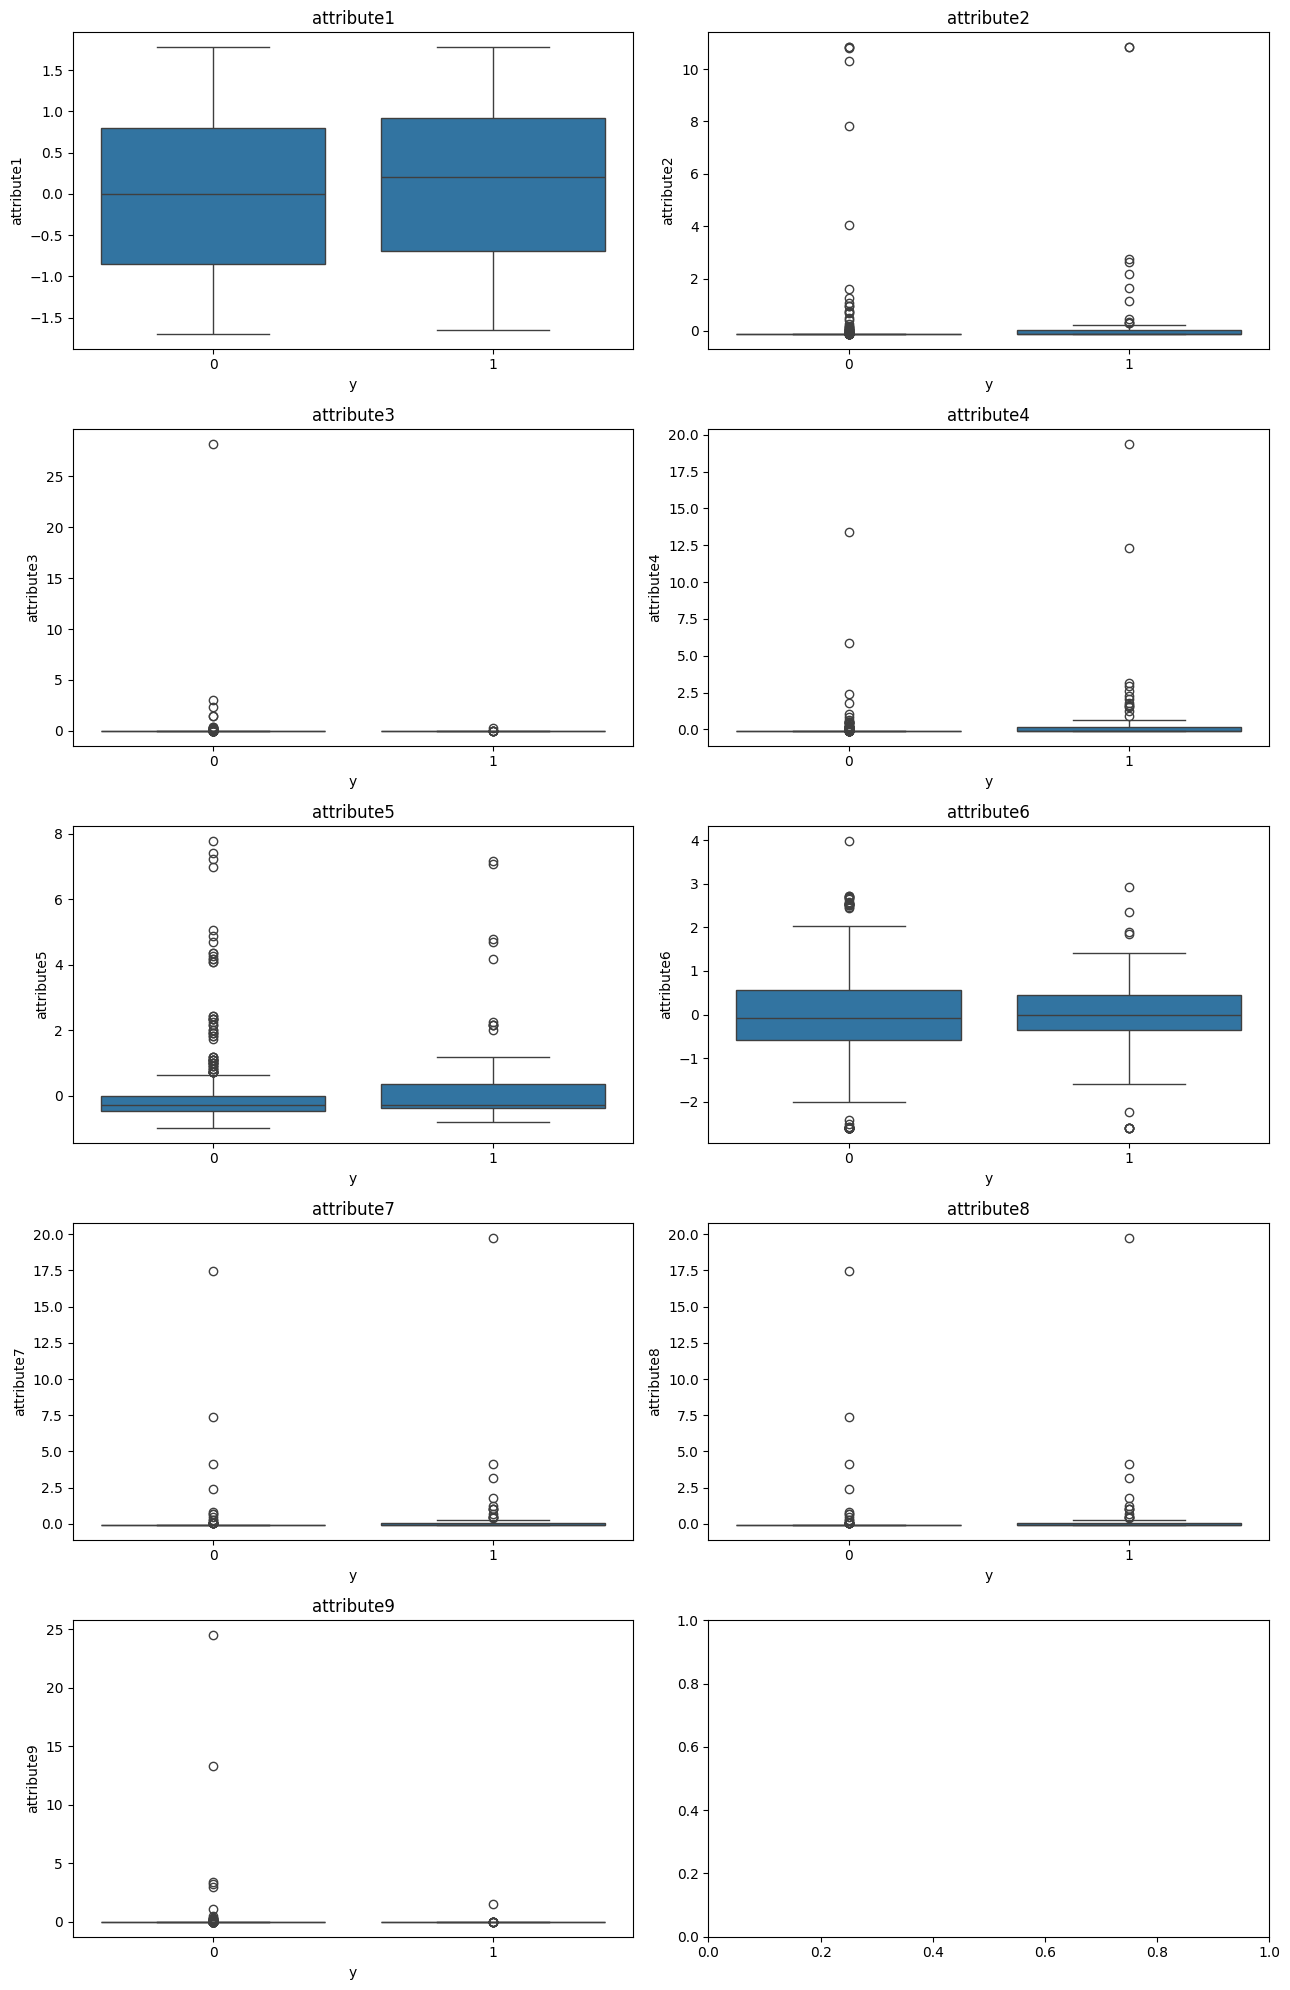

In [20]:
cols = [f"attribute{i}" for i in range(1, 10)]
_, axis = plt.subplots(ncols=2, nrows=int(np.ceil(len(cols)/2)), figsize=(13, 20))
axis = axis.flatten()

for ax, c in zip(axis, cols):
    sns.boxplot(data=pd.concat((X_train_, y_train), axis=1),
                x="y",
                y=c,
                ax=ax)
    ax.set_title(c)
plt.tight_layout()

## Mean vs failure

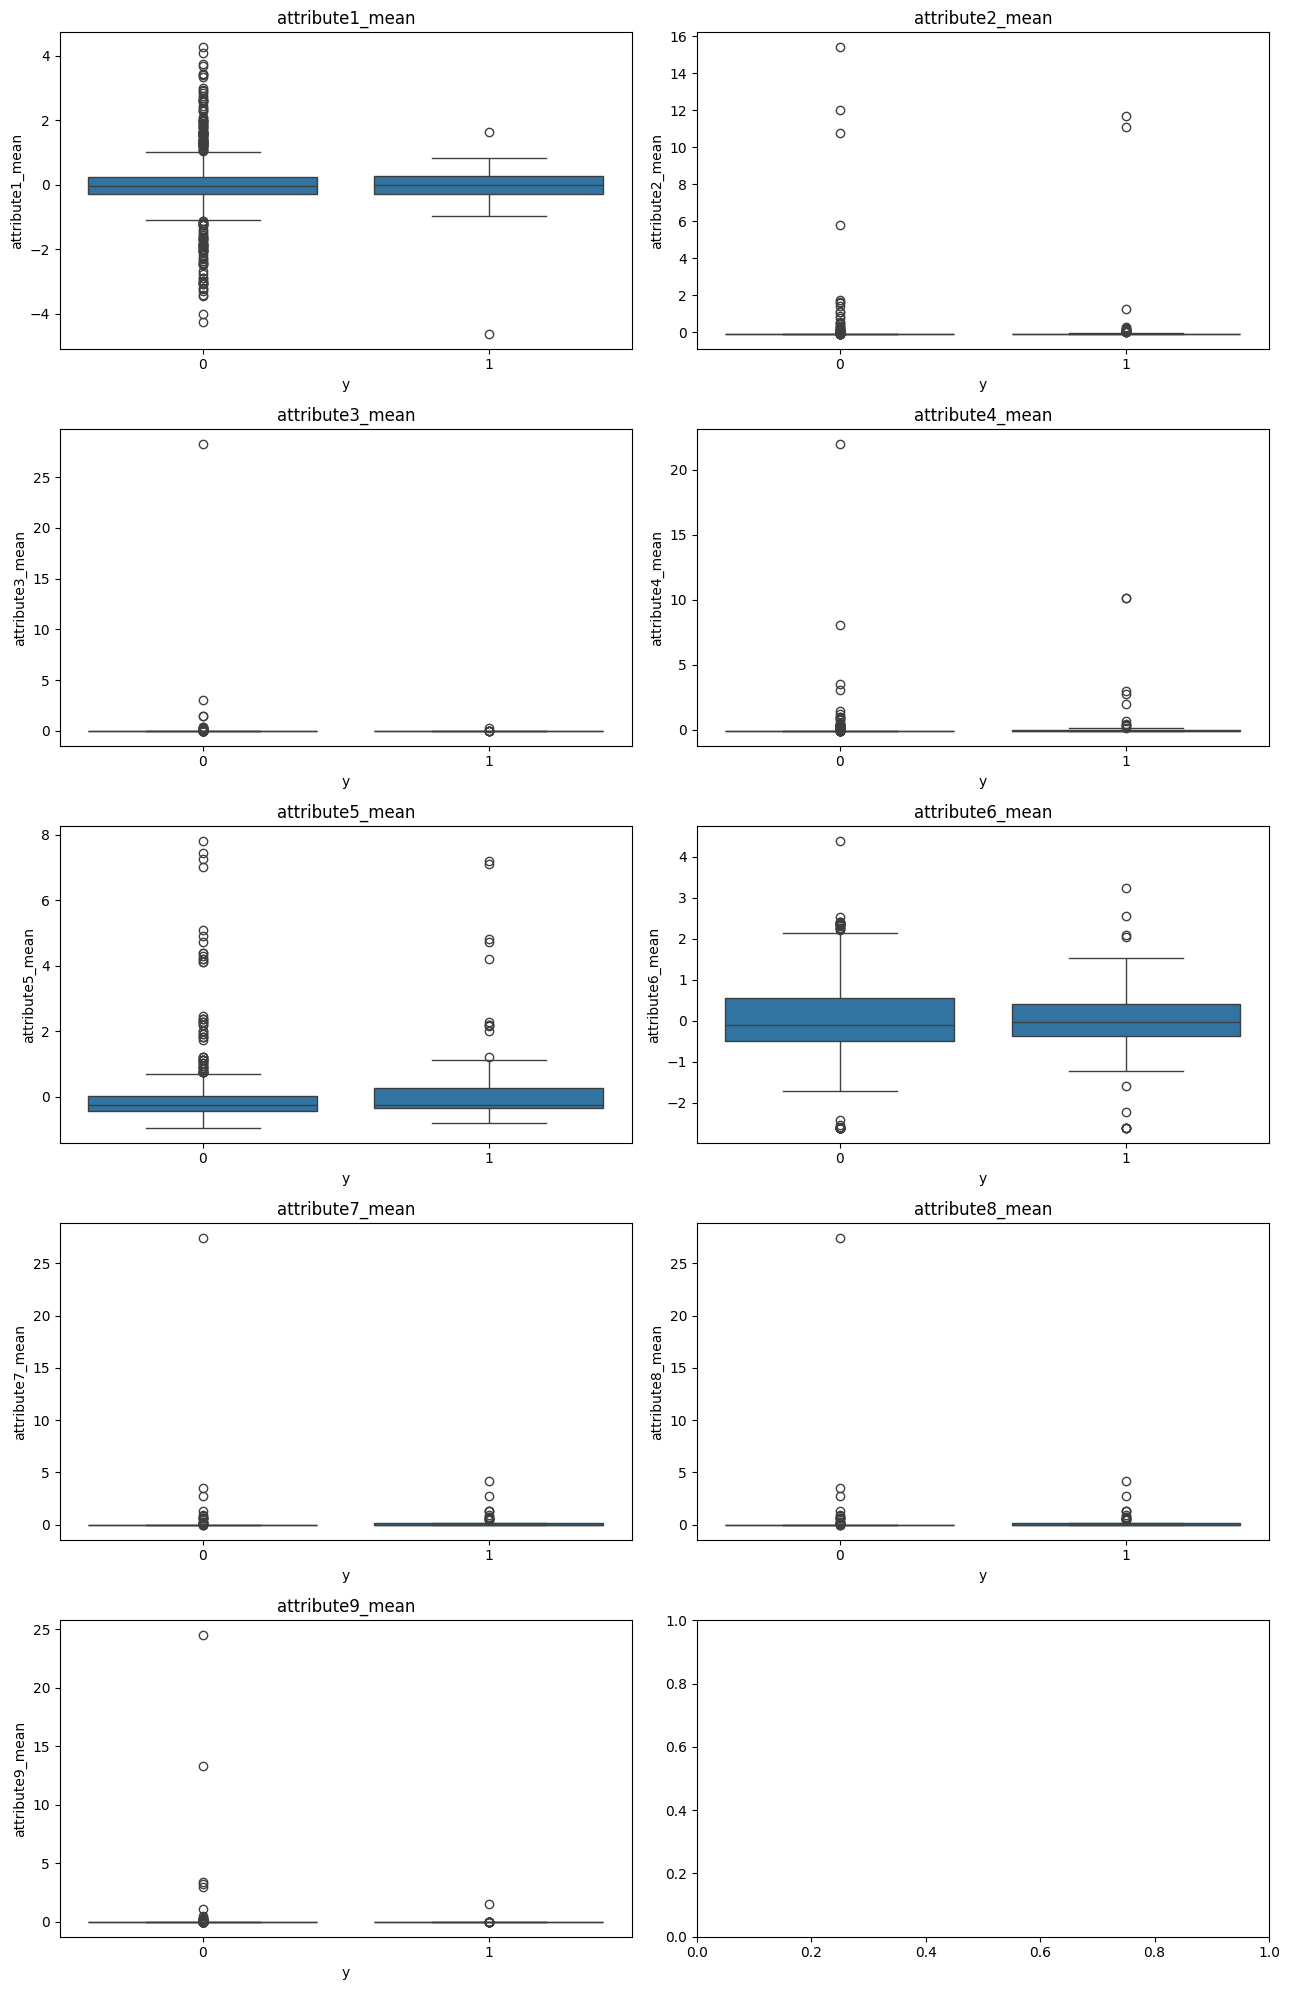

In [21]:
cols = [f"attribute{i}_mean" for i in range(1, 10)]
_, axis = plt.subplots(ncols=2, nrows=int(np.ceil(len(cols)/2)), figsize=(13, 20))
axis = axis.flatten()

for ax, c in zip(axis, cols):
    sns.boxplot(data=pd.concat((X_train_, y_train), axis=1),
                x="y",
                y=c,
                ax=ax)
    ax.set_title(c)
plt.tight_layout()

## Std vs failure

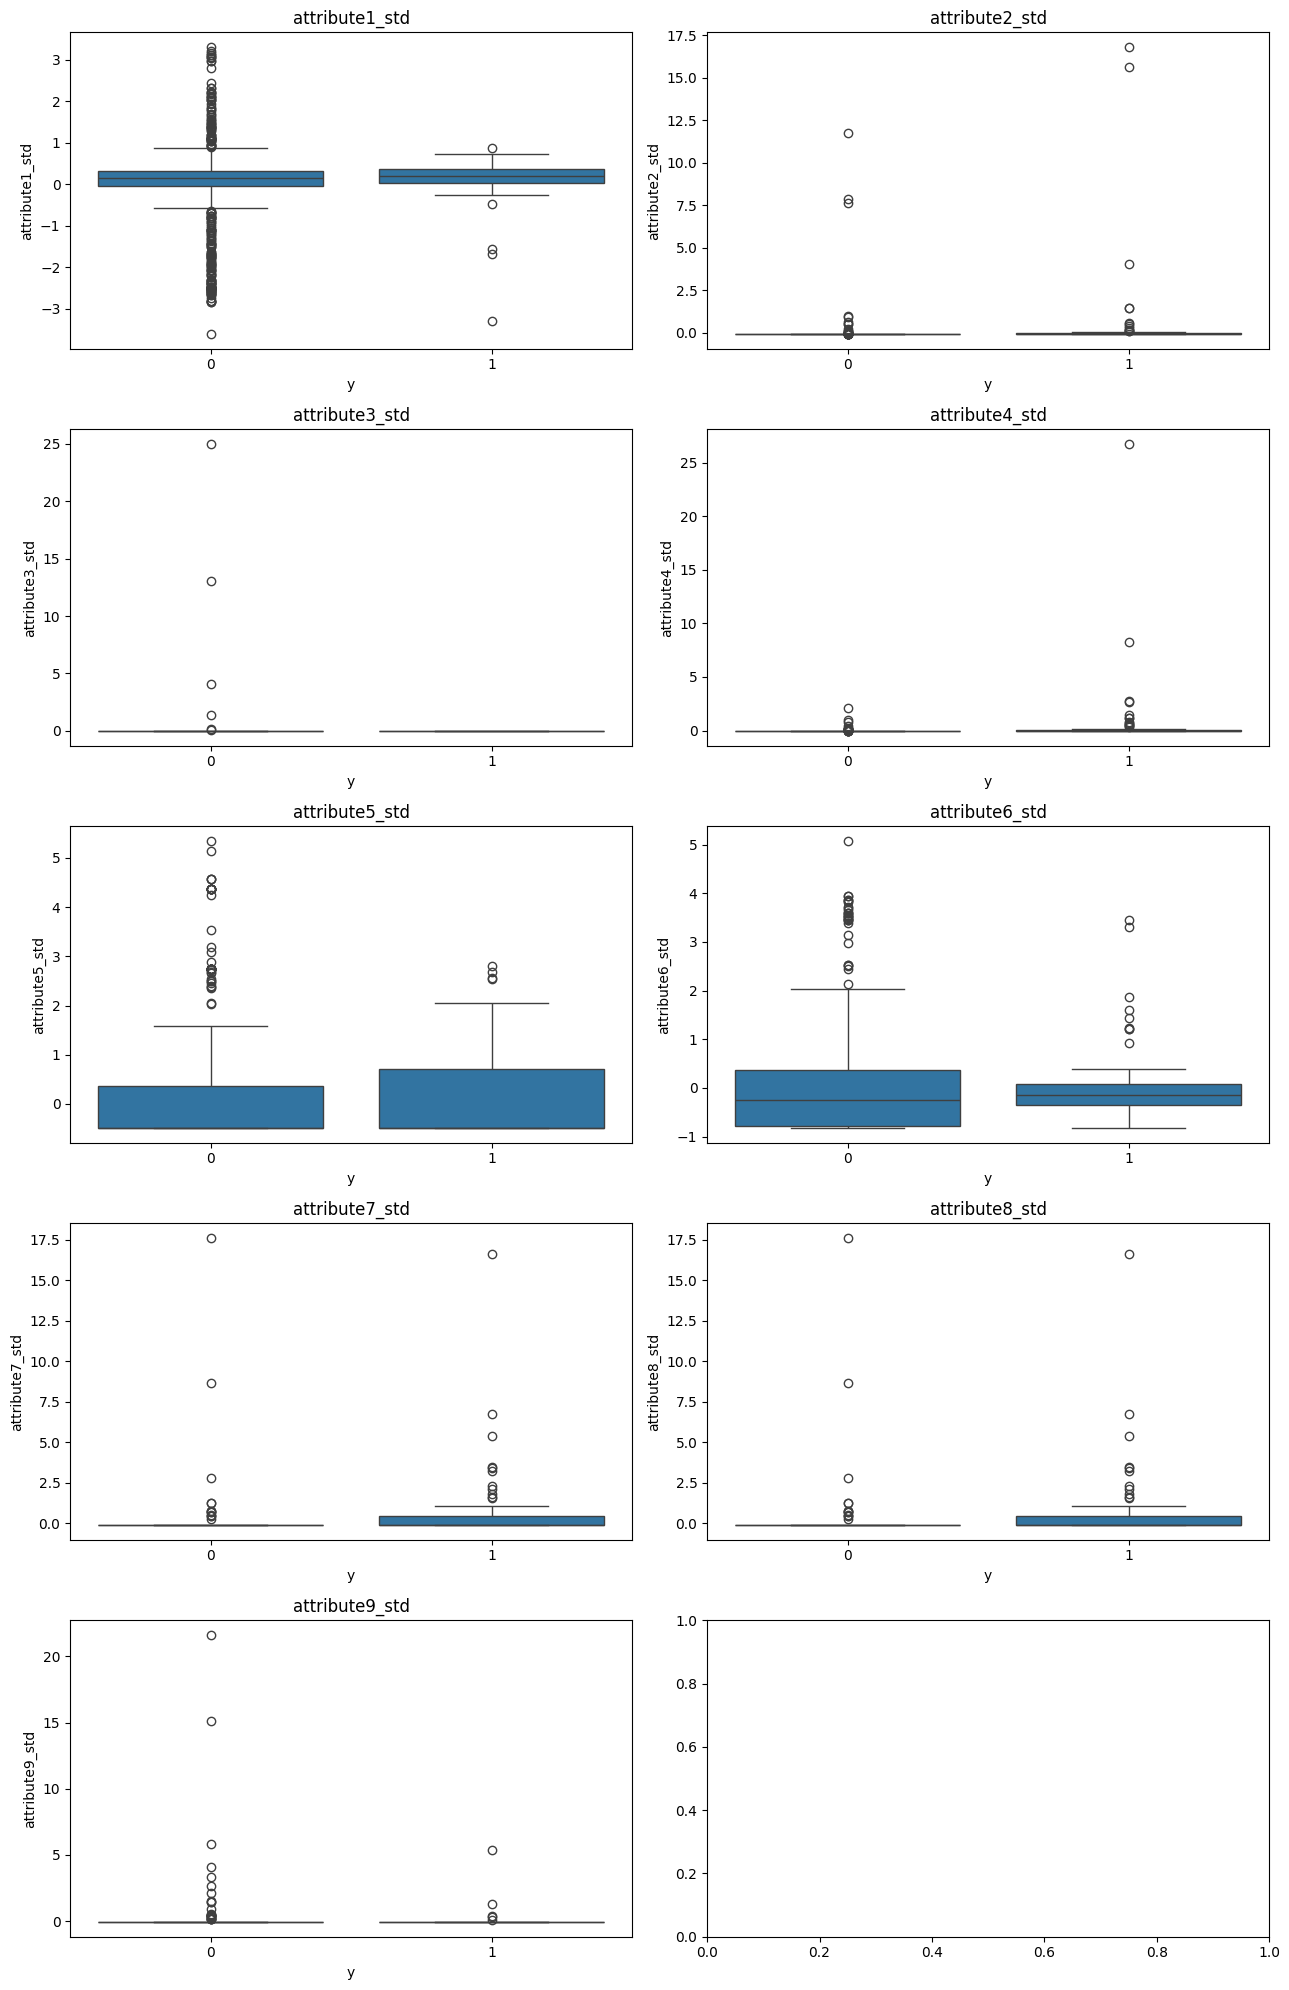

In [22]:
cols = [f"attribute{i}_std" for i in range(1, 10)]
_, axis = plt.subplots(ncols=2, nrows=int(np.ceil(len(cols)/2)), figsize=(13, 20))
axis = axis.flatten()

for ax, c in zip(axis, cols):
    sns.boxplot(data=pd.concat((X_train_, y_train), axis=1),
                x="y",
                y=c,
                ax=ax)
    ax.set_title(c)
plt.tight_layout()

## Lower than mean vs failure

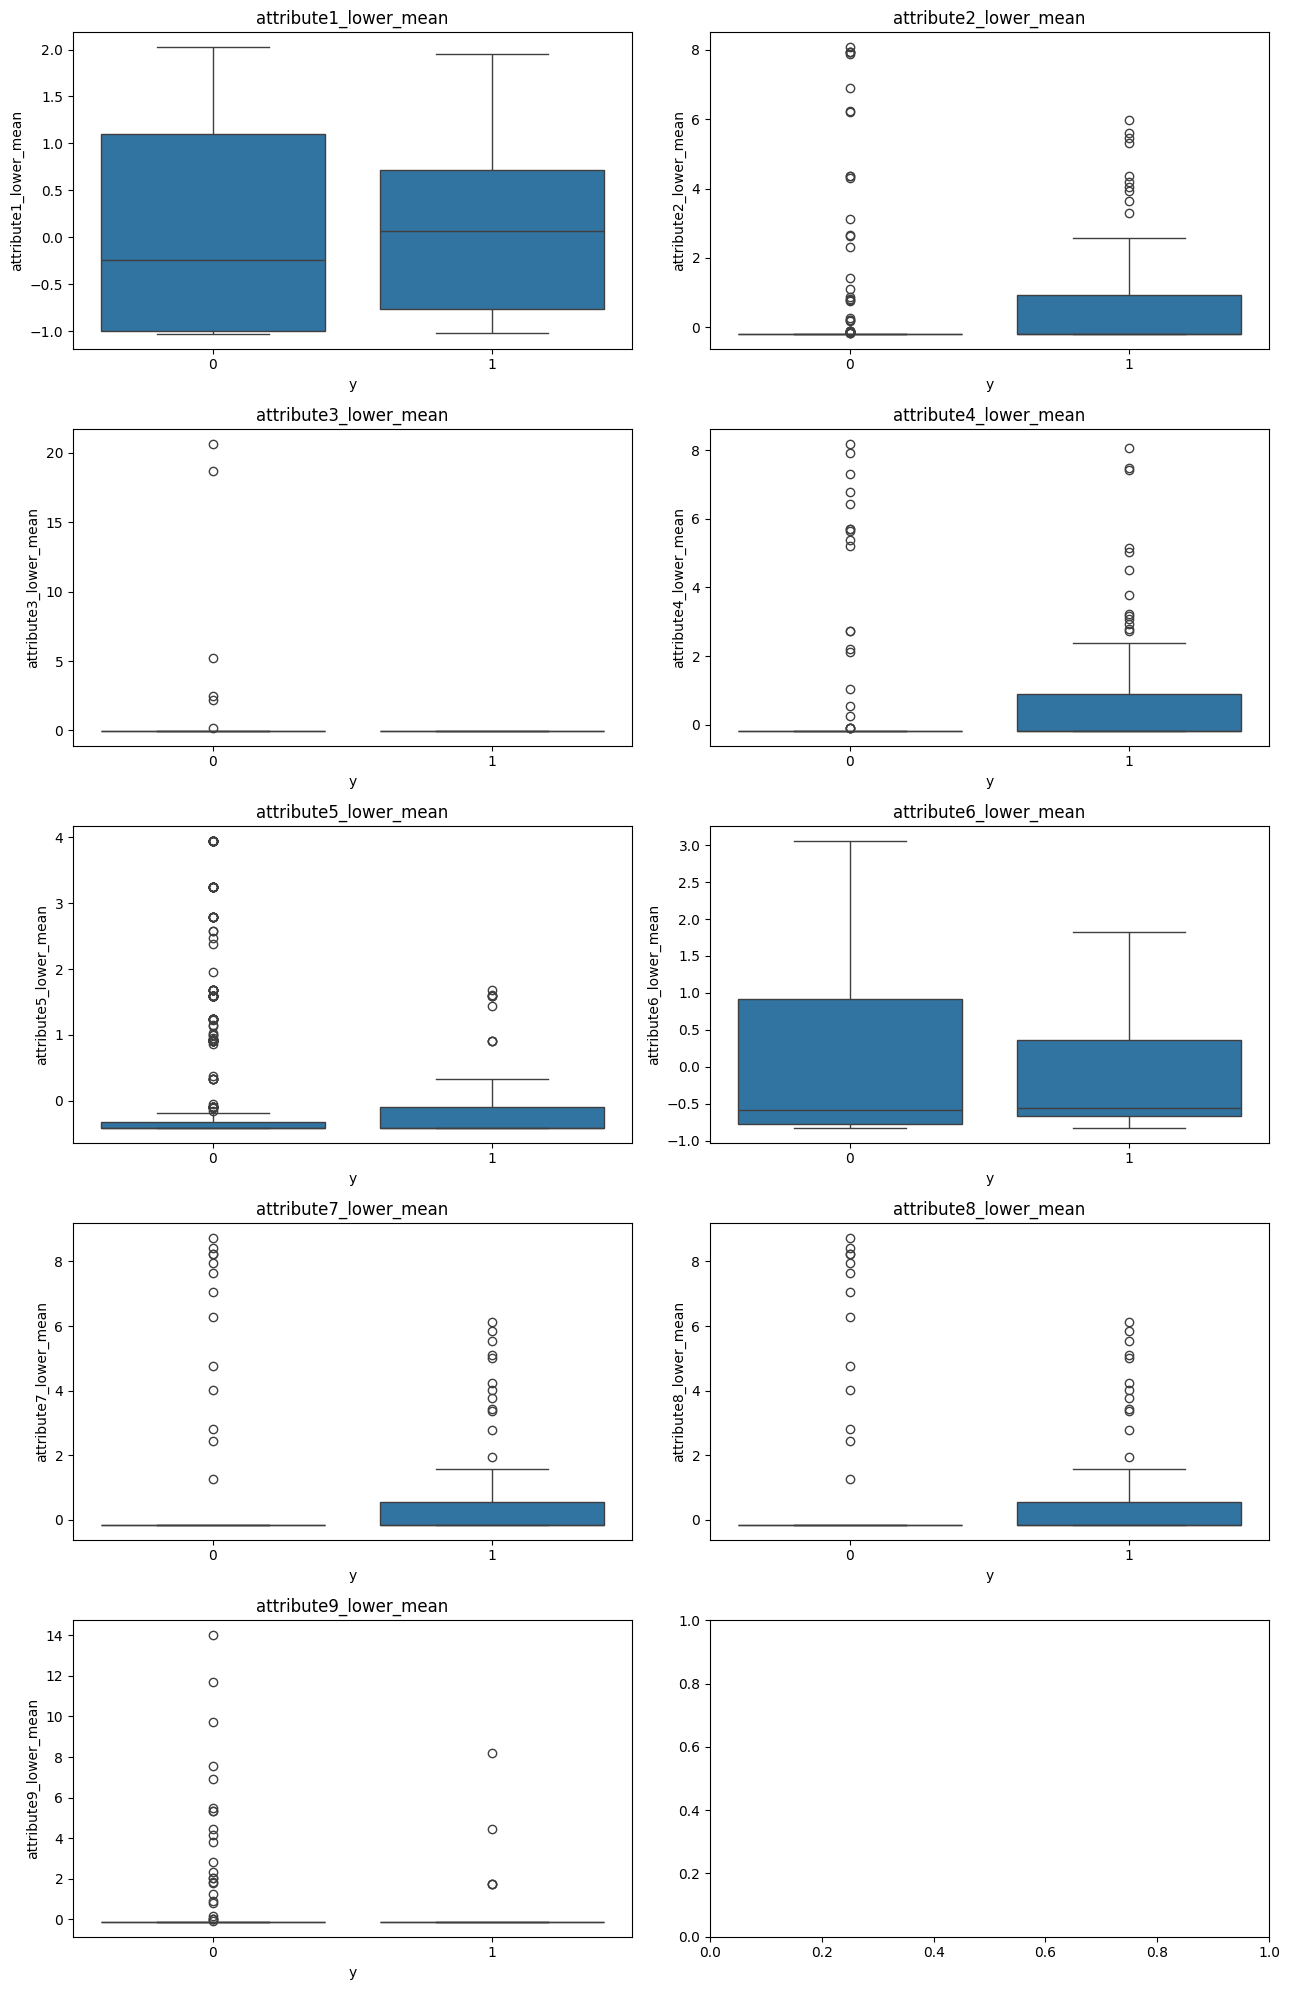

In [23]:
cols = [f"attribute{i}_lower_mean" for i in range(1, 10)]
_, axis = plt.subplots(ncols=2, nrows=int(np.ceil(len(cols)/2)), figsize=(13, 20))
axis = axis.flatten()

for ax, c in zip(axis, cols):
    sns.boxplot(data=pd.concat((X_train_, y_train), axis=1),
                x="y",
                y=c,
                ax=ax)
    ax.set_title(c)
plt.tight_layout()

## Ewm vs failure

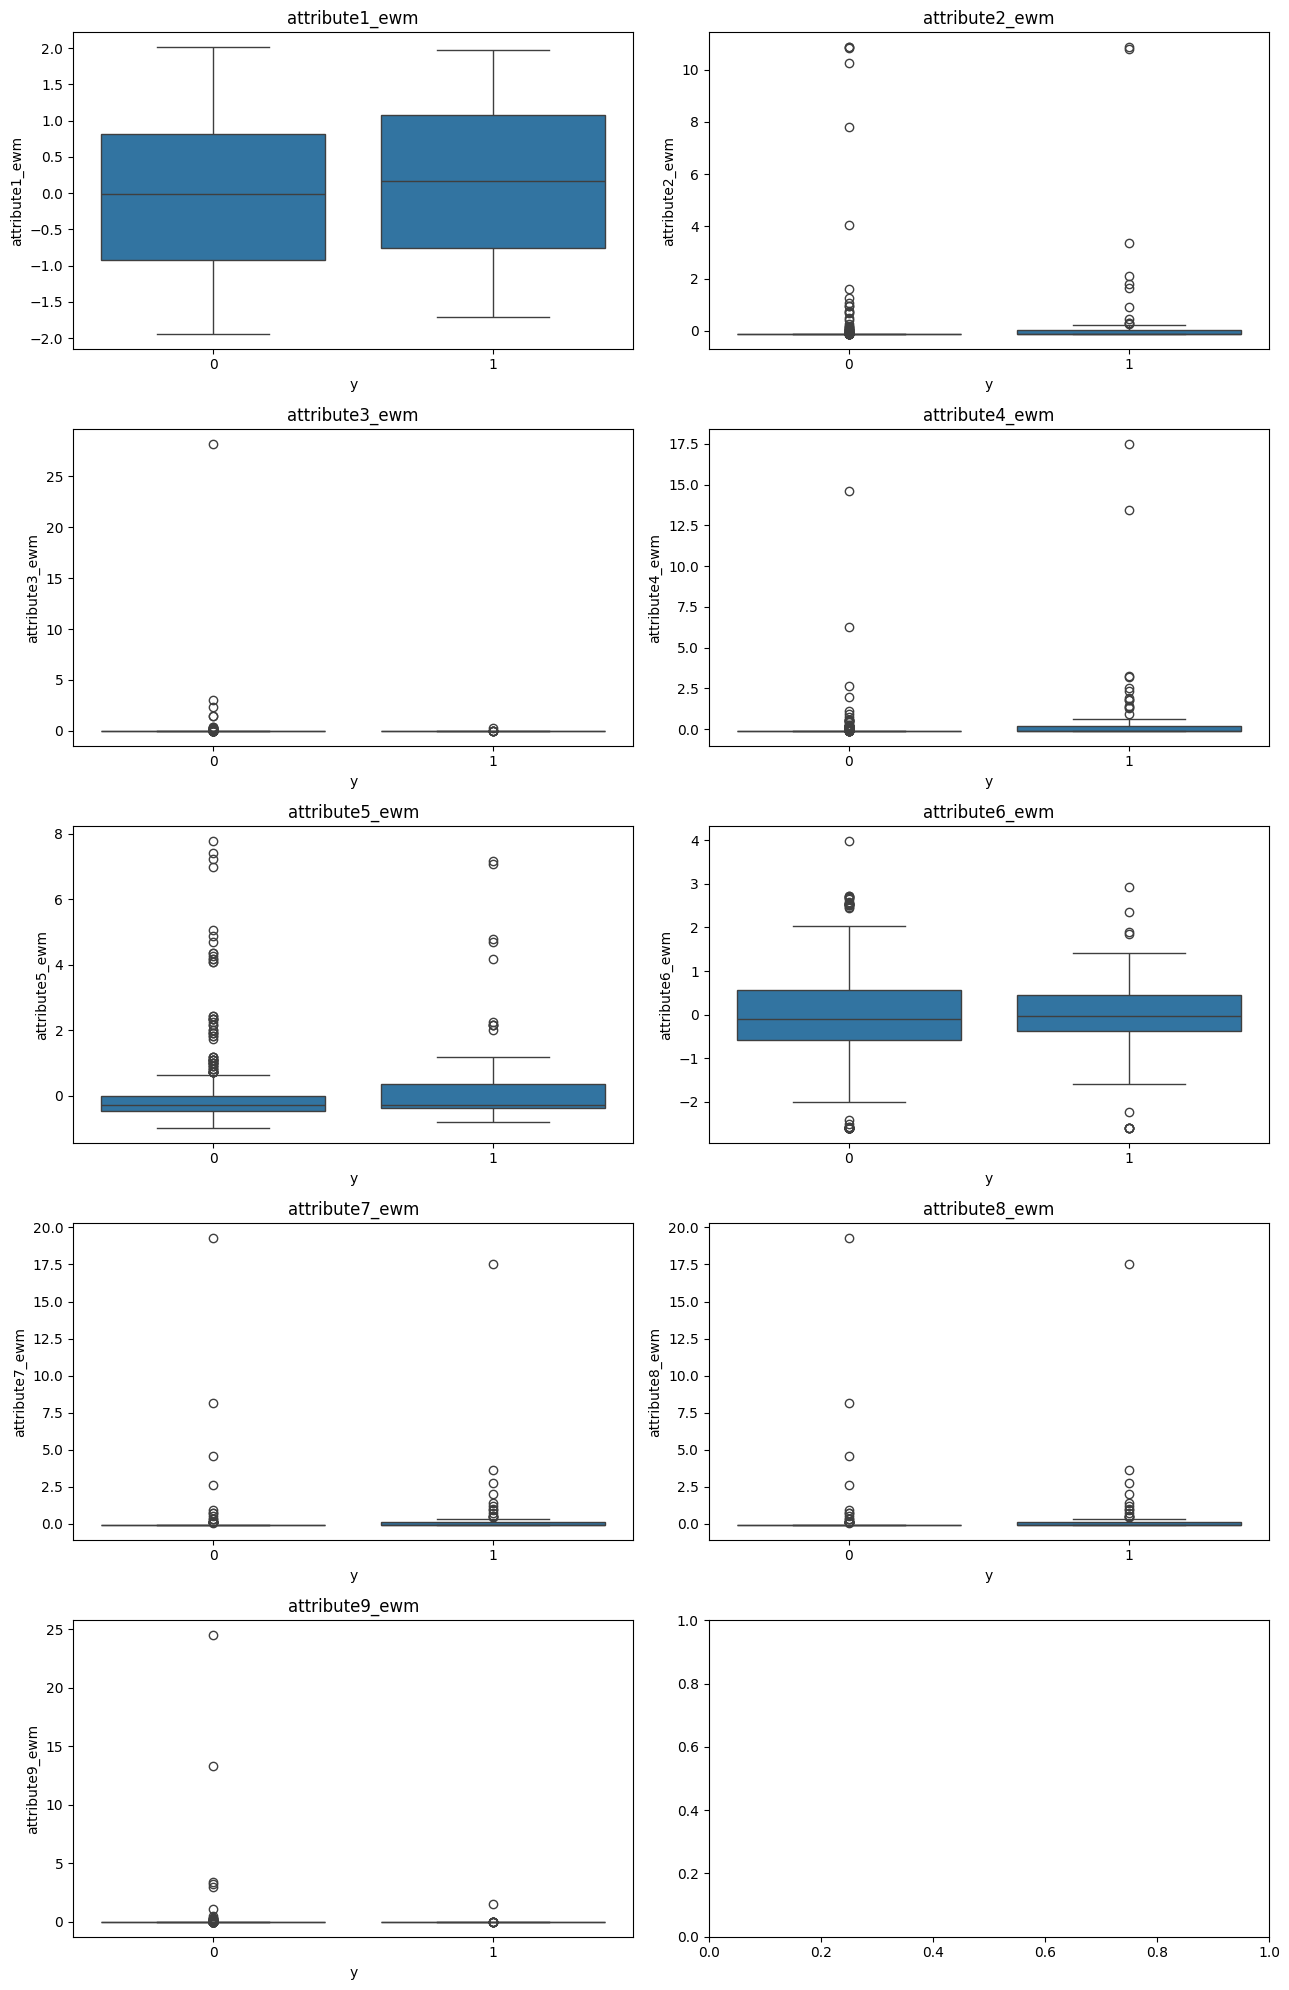

In [24]:
cols = [f"attribute{i}_ewm" for i in range(1, 10)]
_, axis = plt.subplots(ncols=2, nrows=int(np.ceil(len(cols)/2)), figsize=(13, 20))
axis = axis.flatten()

for ax, c in zip(axis, cols):
    sns.boxplot(data=pd.concat((X_train_, y_train), axis=1),
                x="y",
                y=c,
                ax=ax)
    ax.set_title(c)
plt.tight_layout()

## Number of records vs failure

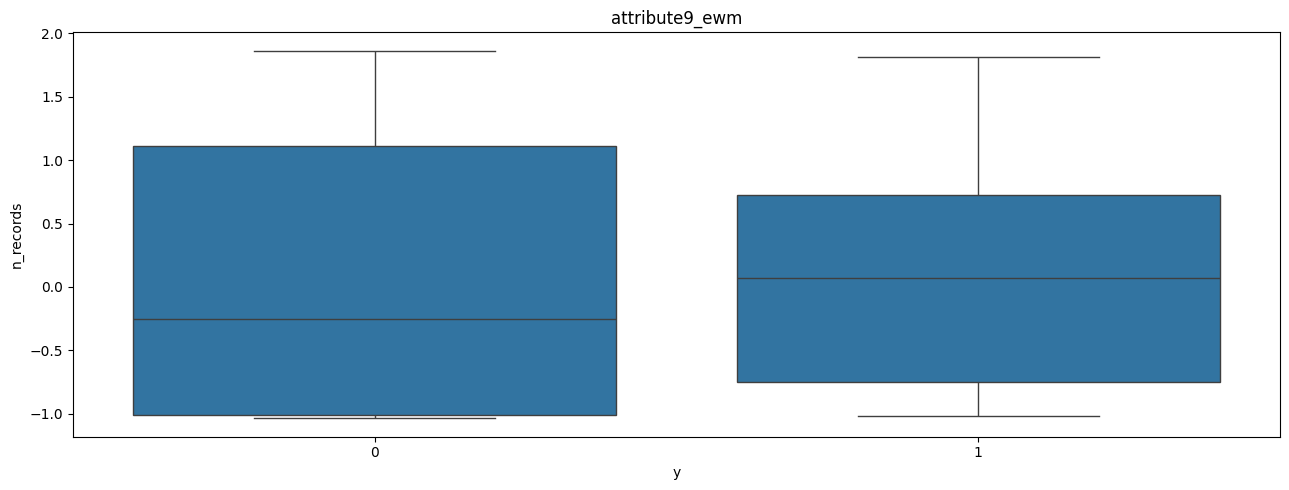

In [25]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(13, 5))
sns.boxplot(data=pd.concat((X_train_, y_train), axis=1),
            x="y",
            y="n_records",
            ax=ax)
ax.set_title(c)
plt.tight_layout()

## Feature importance with RandomForest

In [26]:
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train_, y_train)

RandomForestClassifier(random_state=27)

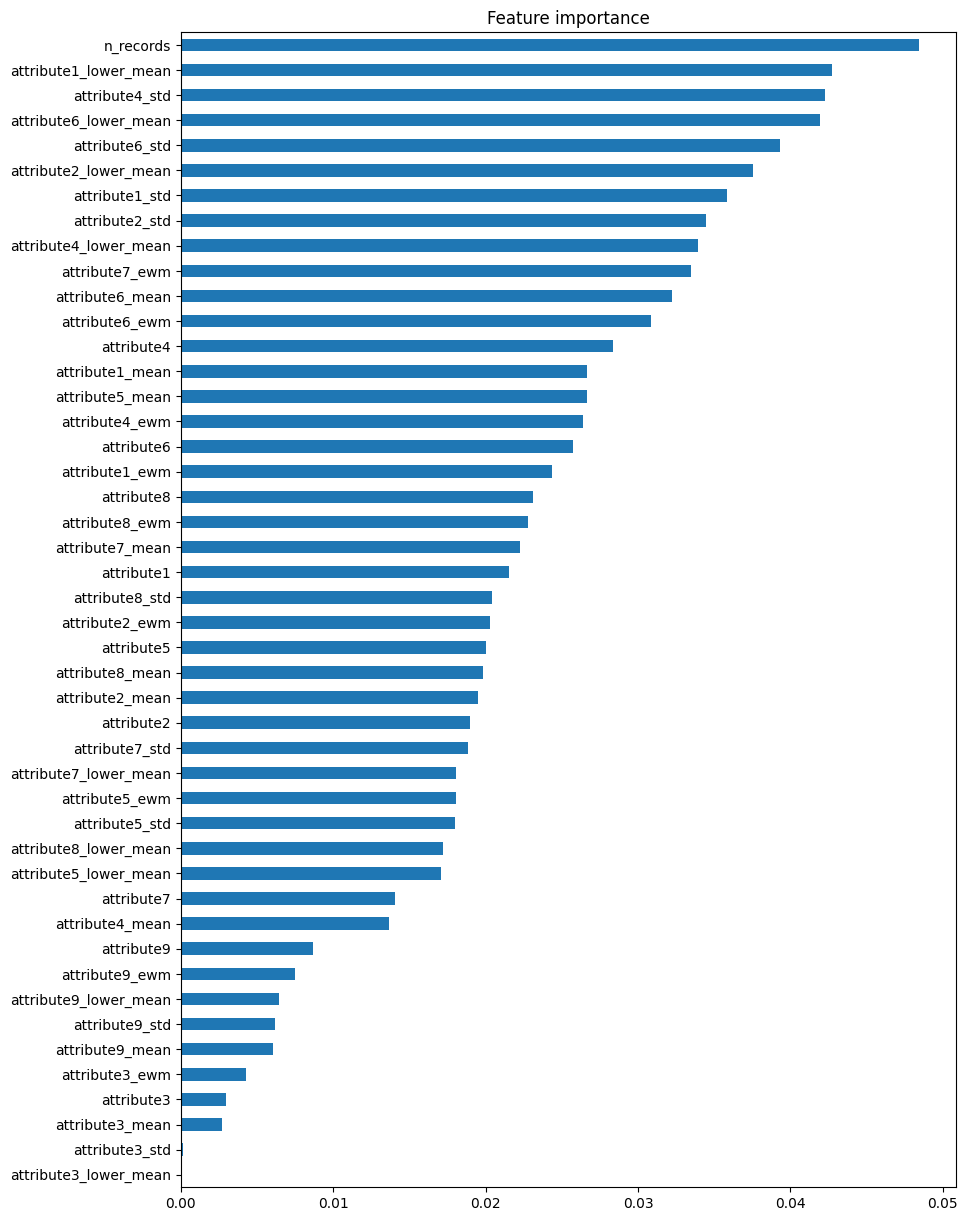

In [27]:
ax = plt.figure(figsize=(10, 15)).gca()
feat_importance = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values()
feat_importance.plot(kind="barh", ax=ax)
ax.set_title("Feature importance")
plt.show()

Let's consider the top 10 to multivariate analyse 

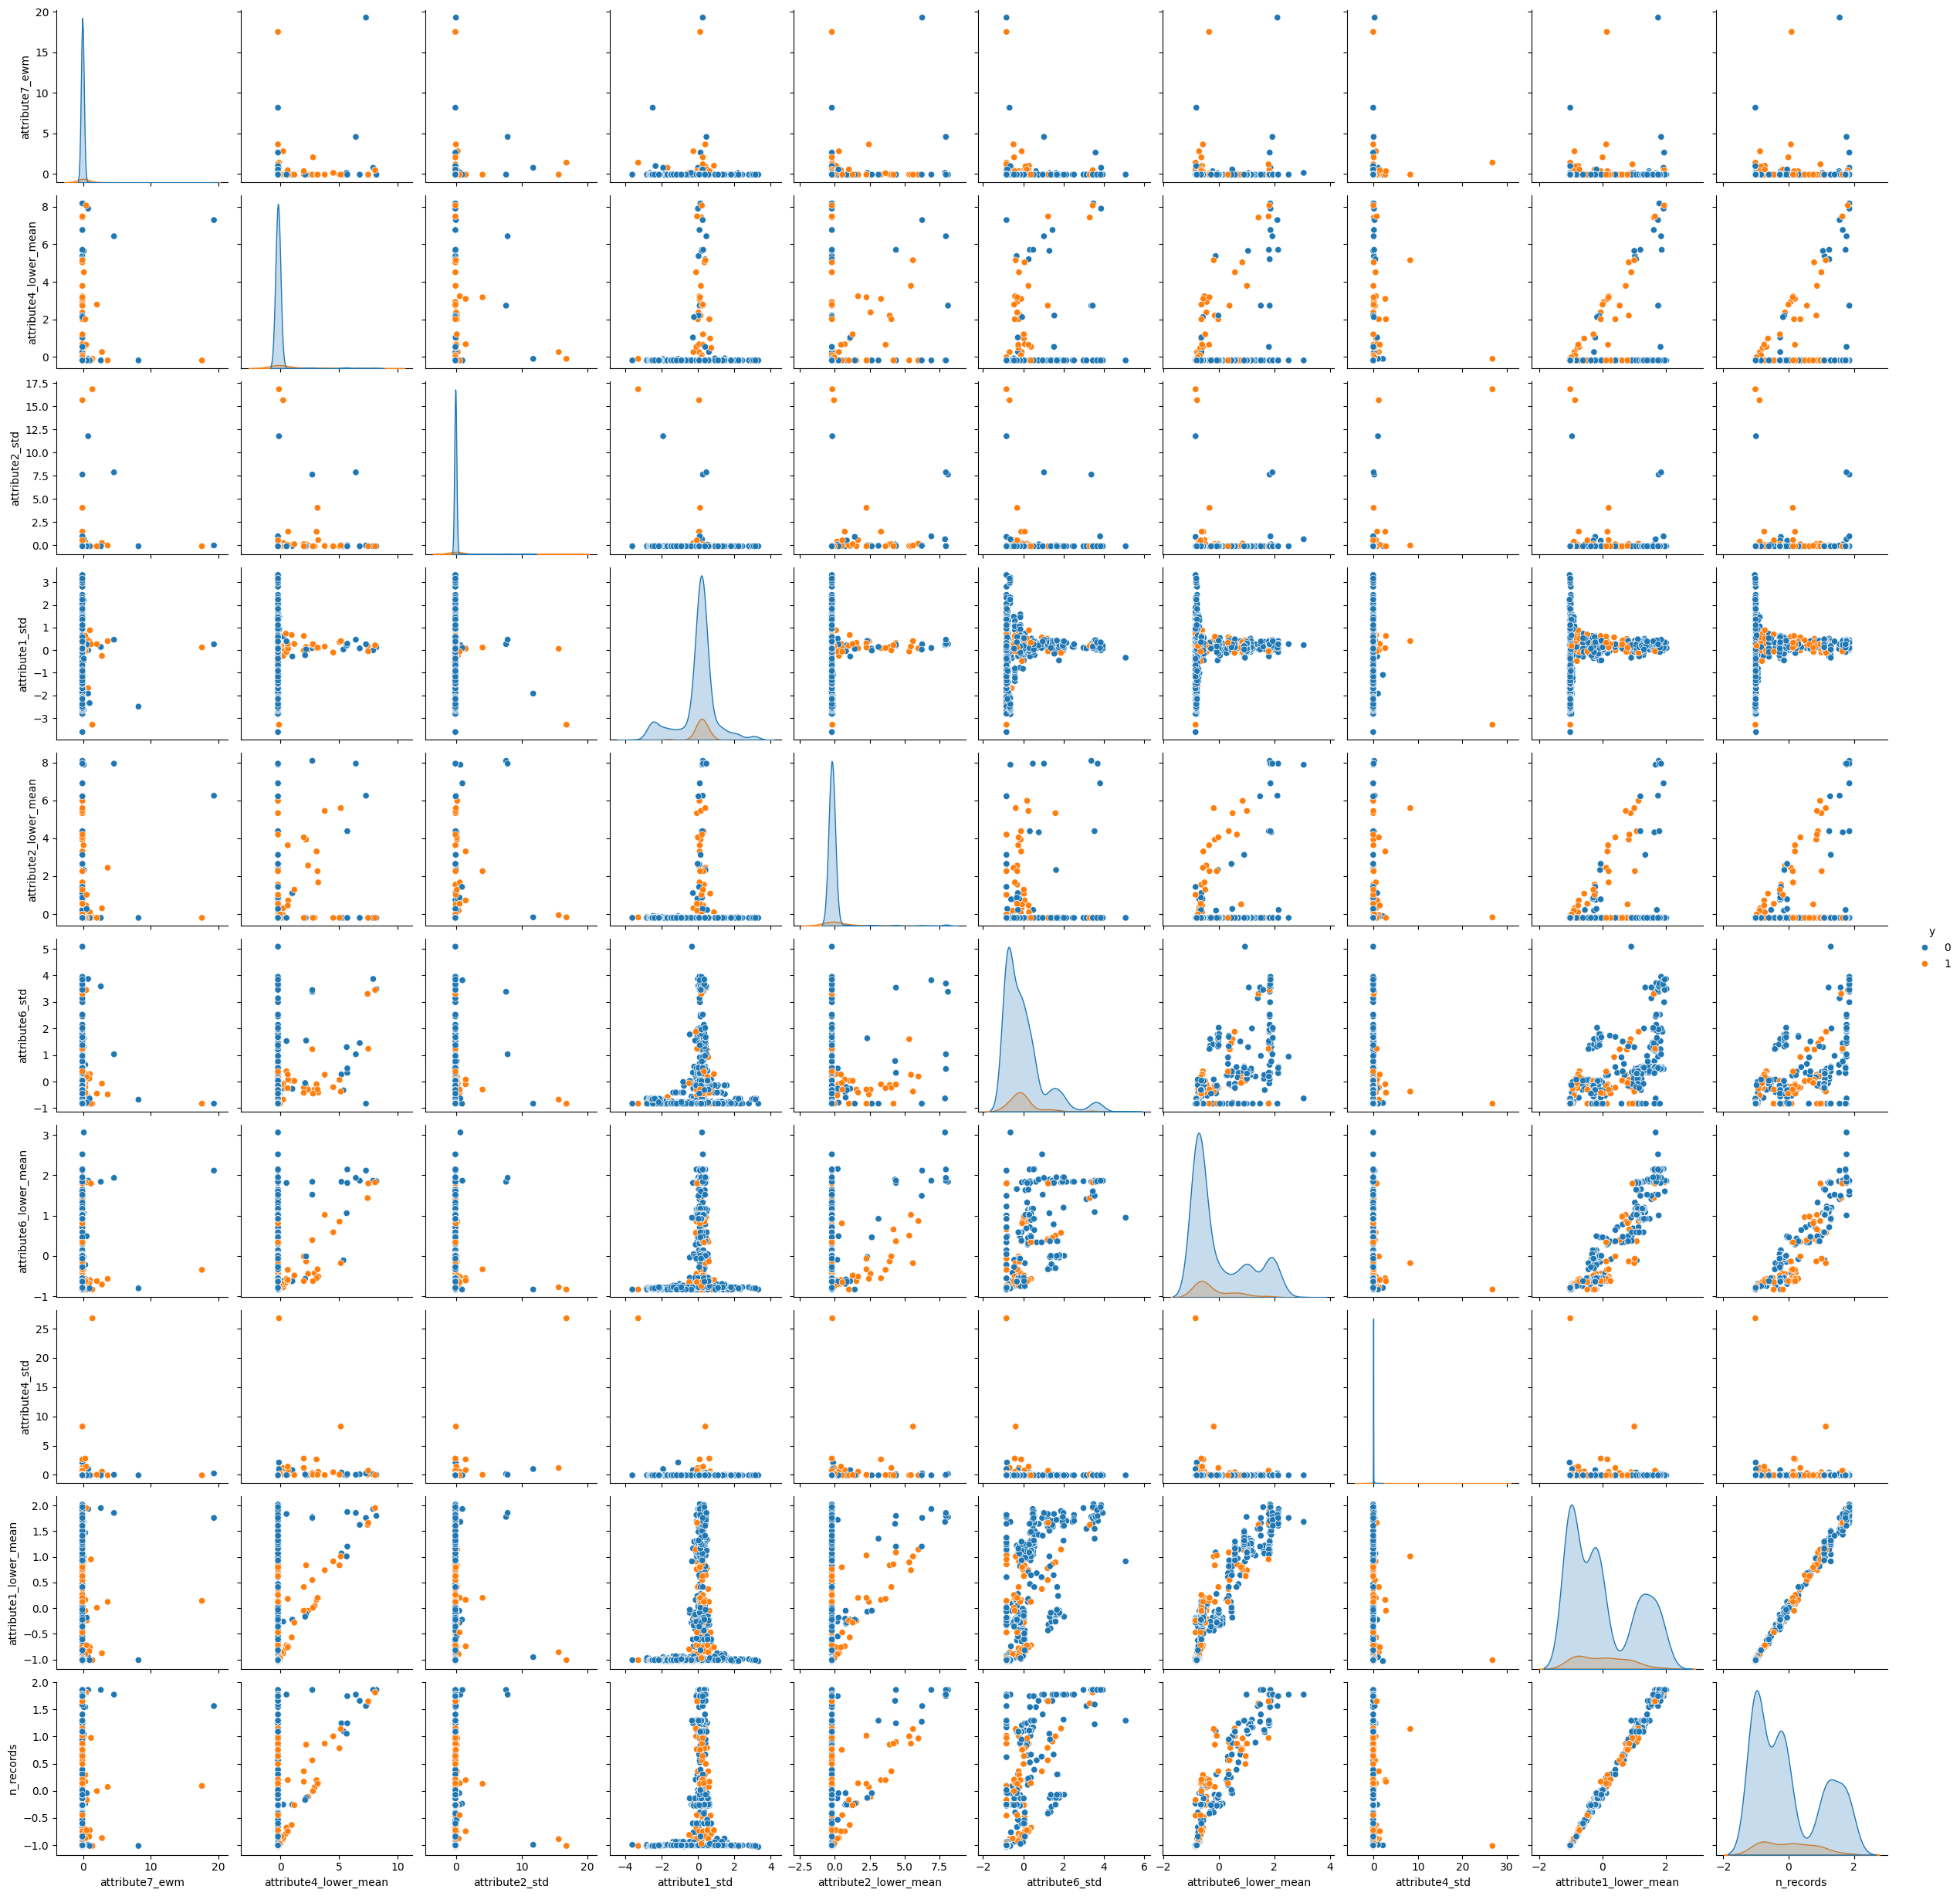

In [28]:
sns.pairplot(data=pd.concat((X_train_[feat_importance.index[-10:]], y_train), axis=1),
             hue="y")

# Train model

In [29]:
# Let's try 3 different models
models = {
    "LGR": LogisticRegression(random_state=random_state),
    "SVM": SVC(random_state=random_state),
    "RF": RandomForestClassifier(random_state=random_state),
    "XGB": XGBClassifier(random_state=random_state,
                         scale_pos_weight=y_train.value_counts().pipe(lambda x: x[0]/x[1])
                        )
}
model_cross = {}
for model_name, m in models.items():
    model_cross[model_name] = cross_val_score(estimator=m,
                    X=X_train_[feat_importance.index[-10:]],
                    y=y_train,
                    cv=StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True),
                    scoring="f1_weighted")

Text(0.5, 1.0, 'Cross validation performance')

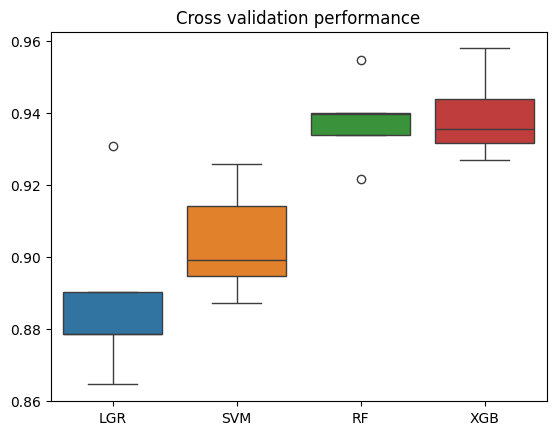

In [30]:
sns.boxplot(pd.DataFrame(model_cross))
plt.title("Cross validation performance")

In [31]:
# Random Forest has the best median and XGBoost the best mean. Let's tune both
pd.DataFrame(model_cross).describe()

,LGR,SVM,RF,XGB
count,5.000000,5.000000,5.000000,5.000000
mean,0.888540,0.904191,0.937991,0.939144
std,0.025362,0.015572,0.011938,0.012231
min,0.864587,0.887154,0.921685,0.926829
25%,0.878473,0.894678,0.933768,0.931591
50%,0.878473,0.899197,0.939722,0.935438
75%,0.890278,0.914189,0.940087,0.943926
max,0.930890,0.925737,0.954693,0.957934


# Tunning

In [32]:
# Tunning parameters
tunning = {
    "XGB": {
        "model": XGBClassifier(random_state=random_state,
                               scale_pos_weight=y_train.value_counts().pipe(lambda x: x[0]/x[1])
                               ),
        "parameters": {
            "min_child_weight": uniform(loc=0, scale=500),
            "max_depth": randint(0, 30),
            "reg_alpha": uniform(loc=0, scale=10),
            "reg_lambda": uniform(loc=0, scale=10),
            "subsample": uniform(loc=0, scale=1),
        }
    },
    "RF": {
        "model": RandomForestClassifier(random_state=random_state),
        "parameters": {
            "max_depth": [None] + [i for i in range(1, 31)],
            "ccp_alpha": uniform(loc=0, scale=10),
            "n_estimators": randint(2, 300)
        }
    }
}

rscv = {}
for k, t in tunning.items():
    rscv[k] = RandomizedSearchCV(estimator=t["model"],
                              scoring="f1_weighted",
                              n_iter=20,
                              random_state=random_state,
                              cv=StratifiedKFold(n_splits=5,
                                                 random_state=random_state,
                                                 shuffle=True),
                              param_distributions=t["parameters"])
    rscv[k].fit(X_train_[feat_importance.index[-10:]], y_train)

In [33]:
print("Random Forest", rscv["RF"].best_params_)
print("XGBoost", rscv["XGB"].best_params_)

Random Forest {'ccp_alpha': np.float64(0.014566952404879707), 'max_depth': 12, 'n_estimators': 261}
XGBoost {'max_depth': 27, 'min_child_weight': np.float64(9.032583216280754), 'reg_alpha': np.float64(1.2666858789352298), 'reg_lambda': np.float64(7.362030604293713), 'subsample': np.float64(0.20699591909695902)}


In [34]:
model_cross["BEST_RF"] = [v[rscv["RF"].best_index_] for k, v in rscv["RF"].cv_results_.items() if "split" in k]
model_cross["BEST_XGB"] = [v[rscv["XGB"].best_index_] for k, v in rscv["XGB"].cv_results_.items() if "split" in k]

Text(0.5, 1.0, 'Cross validation performance for each classifier with the tunned model')

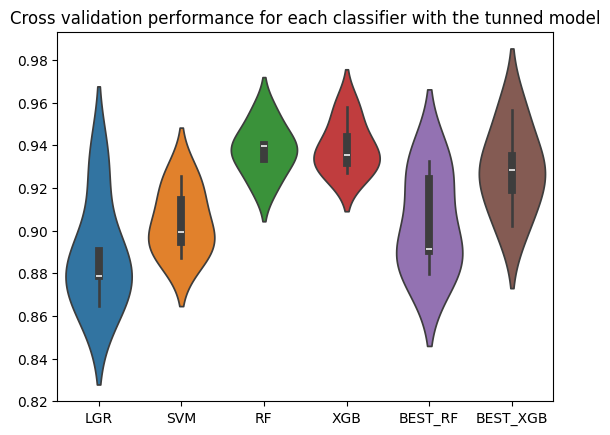

In [35]:
# The best model did not have a great performance after the tunning. Let's consider the default one
sns.violinplot(pd.DataFrame(model_cross))
plt.title("Cross validation performance for each classifier with the tunned model")

In [36]:
# The default values have better performance than the tunned ones
pd.DataFrame(model_cross).describe()

,LGR,SVM,RF,XGB,BEST_RF,BEST_XGB
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.888540,0.904191,0.937991,0.939144,0.903634,0.928176
std,0.025362,0.015572,0.011938,0.012231,0.023267,0.020038
min,0.864587,0.887154,0.921685,0.926829,0.879633,0.902058
25%,0.878473,0.894678,0.933768,0.931591,0.890278,0.919005
50%,0.878473,0.899197,0.939722,0.935438,0.891429,0.928644
75%,0.890278,0.914189,0.940087,0.943926,0.924315,0.934789
max,0.930890,0.925737,0.954693,0.957934,0.932517,0.956387


# Test Evaluation

In [37]:
# Finally, let's test the default RF and XGB models to define the choosen one
X_test, y_test = f.transform(df_test.drop(columns=y_col), df_test[y_col])

In [38]:
X_test_ = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

In [39]:
xgb = XGBClassifier(random_state=random_state,
                    scale_pos_weight=y_train.value_counts().pipe(lambda x: x[0]/x[1]))
rf = RandomForestClassifier(random_state=random_state)
features_predict = feat_importance.index[-10:]

In [40]:
xgb.fit(X_train_[features_predict], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [41]:
rf.fit(X_train_[features_predict], y_train)

RandomForestClassifier(random_state=27)

In [43]:
confusion_matrix(y_pred=xgb.predict(X_test_[features_predict]), y_true=y_test)

array([[309,  10],
       [  6,  26]])

In [44]:
confusion_matrix(y_pred=rf.predict(X_test_[features_predict]), y_true=y_test)

array([[311,   8],
       [ 12,  20]])

In [45]:
print("XGB: Precision", precision_score(y_pred=xgb.predict(X_test_[features_predict]), y_true=y_test), "\n",
      "Recall", recall_score(y_pred=xgb.predict(X_test_[features_predict]), y_true=y_test), "\n",
      "F1 weighted", f1_score(y_pred=xgb.predict(X_test_[features_predict]), y_true=y_test, average="weighted"))

XGB: Precision 0.7222222222222222 
 Recall 0.8125 
 F1 weighted 0.9556128633879608


In [46]:
print("RF: Precision", precision_score(y_pred=rf.predict(X_test_[features_predict]), y_true=y_test), "\n",
      "Recall", recall_score(y_pred=rf.predict(X_test_[features_predict]), y_true=y_test), "\n",
      "F1 weighted", f1_score(y_pred=rf.predict(X_test_[features_predict]), y_true=y_test, average="weighted"))

RF: Precision 0.7142857142857143 
 Recall 0.625 
 F1 weighted 0.9412981157529444


So our model would be the XGBoost!

# Next Steps
As next steps/improvements, we can mention:

- Feature engineering: we could look for additional features and even interactions between existing ones. Moreover, we could apply further data transformations to meet the assumptions of other models, such as logistic regression.
- Variable selection: we could apply other variable selection strategies, such as Boruta.
- Model selection: given the nature of the problem, the F1 score may not be the most suitable metric. We would need a deeper understanding in collaboration with the business stakeholders.
- Tuning: applying other methods, such as Optuna; performing additional rounds of iteration; and even evaluating other hyperparameters.